In [ ]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.patches import Rectangle
import numpy as np
from scipy.stats import linregress

from functions import win_loss, get_team_schedule, fantasy_defense_rankings

In [2]:

week_by_week2024 = nfl.import_weekly_data([2024], downcast=True)
play_by_play2024 = nfl.import_pbp_data([2024], downcast=True, cache=False, alt_path=None)
schedule2024 = nfl.import_schedules([2024])
seasonal2024 = nfl.import_seasonal_data([2024], "REG")
winstotal2024 = nfl.import_win_totals([2024])

Downcasting floats.
2024 done.
Downcasting floats.


In [ ]:
for columns in seasonal2024.columns:
    print(columns)

In [ ]:
# printing the columns of play_byPlay so I don't mess up names lol
for column in play_by_play2024.columns:
    print(column)

In [ ]:
for column in schedule2024.columns:
    print(column)
    

In [53]:
# printing the columns of week_by_week so I don't mess up names lol
for columns in week_by_week2024.columns: 
    print (columns)


# small_wbw_df = week_by_week2024[["recent_team", "player_name", "fantasy_points_ppr", "wopr", "dakota", "position"]]

# # justin jefferson
# small_wbw_df[(small_wbw_df["recent_team"] == "CIN") & (small_wbw_df["position"] == "WR")]


week10 = week_by_week2024[week_by_week2024["player_name"] == "N.Collins"]
week10

player_id
player_name
player_display_name
position
position_group
headshot_url
recent_team
season
week
season_type
opponent_team
completions
attempts
passing_yards
passing_tds
interceptions
sacks
sack_yards
sack_fumbles
sack_fumbles_lost
passing_air_yards
passing_yards_after_catch
passing_first_downs
passing_epa
passing_2pt_conversions
pacr
dakota
carries
rushing_yards
rushing_tds
rushing_fumbles
rushing_fumbles_lost
rushing_first_downs
rushing_epa
rushing_2pt_conversions
receptions
targets
receiving_yards
receiving_tds
receiving_fumbles
receiving_fumbles_lost
receiving_air_yards
receiving_yards_after_catch
receiving_first_downs
receiving_epa
receiving_2pt_conversions
racr
target_share
air_yards_share
wopr
special_teams_tds
fantasy_points
fantasy_points_ppr


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
1425,00-0036554,N.Collins,Nico Collins,WR,WR,https://static.www.nfl.com/image/upload/f_auto...,HOU,2024,1,REG,...,6.0,9.328884,0,0.943548,0.258065,0.500000,0.737097,0.0,11.7,17.700001
1426,00-0036554,N.Collins,Nico Collins,WR,WR,https://static.www.nfl.com/image/upload/f_auto...,HOU,2024,2,REG,...,6.0,8.556203,0,1.115703,0.294118,0.468992,0.769471,0.0,19.5,27.500000
1427,00-0036554,N.Collins,Nico Collins,WR,WR,https://static.www.nfl.com/image/upload/f_auto...,HOU,2024,3,REG,...,4.0,-2.734185,0,0.860000,0.232558,0.377358,0.612988,0.0,8.6,12.600000
1428,00-0036554,N.Collins,Nico Collins,WR,WR,https://static.www.nfl.com/image/upload/f_auto...,HOU,2024,4,REG,...,9.0,9.169621,0,1.070922,0.384615,0.463816,0.901594,0.0,21.1,33.099998
1429,00-0036554,N.Collins,Nico Collins,WR,WR,https://static.www.nfl.com/image/upload/f_auto...,HOU,2024,5,REG,...,2.0,5.797637,0,1.444444,0.057143,0.250000,0.260714,0.0,13.8,15.800000


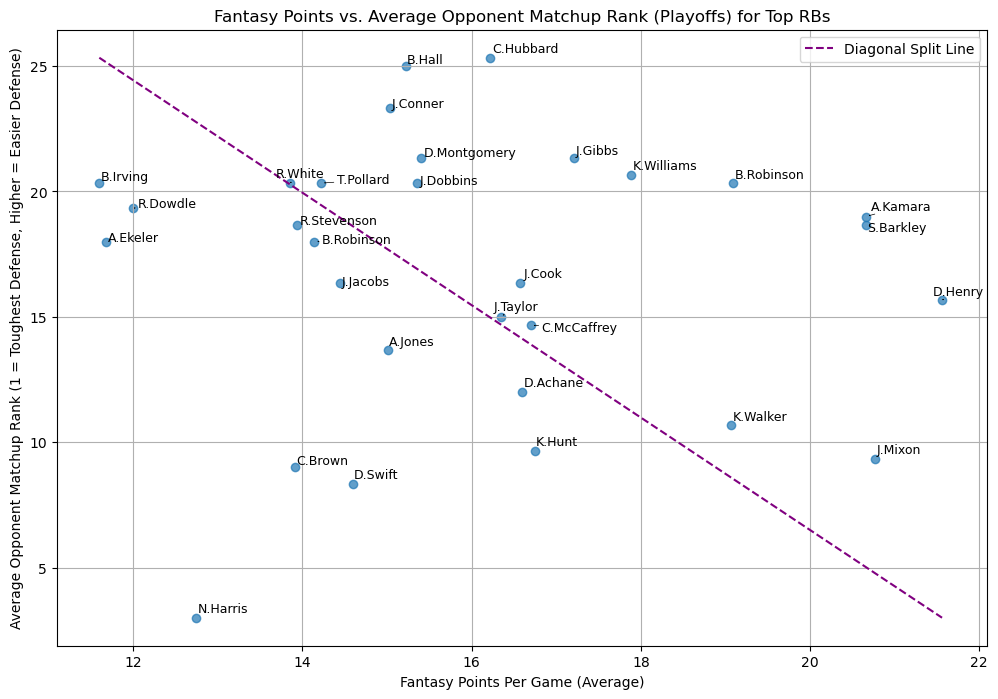

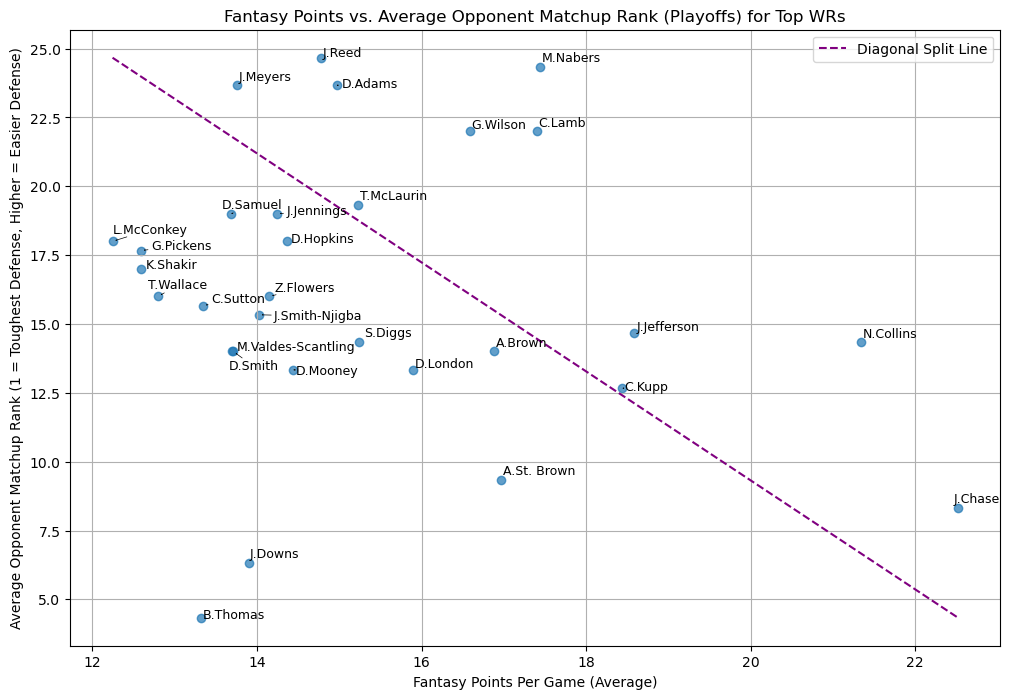

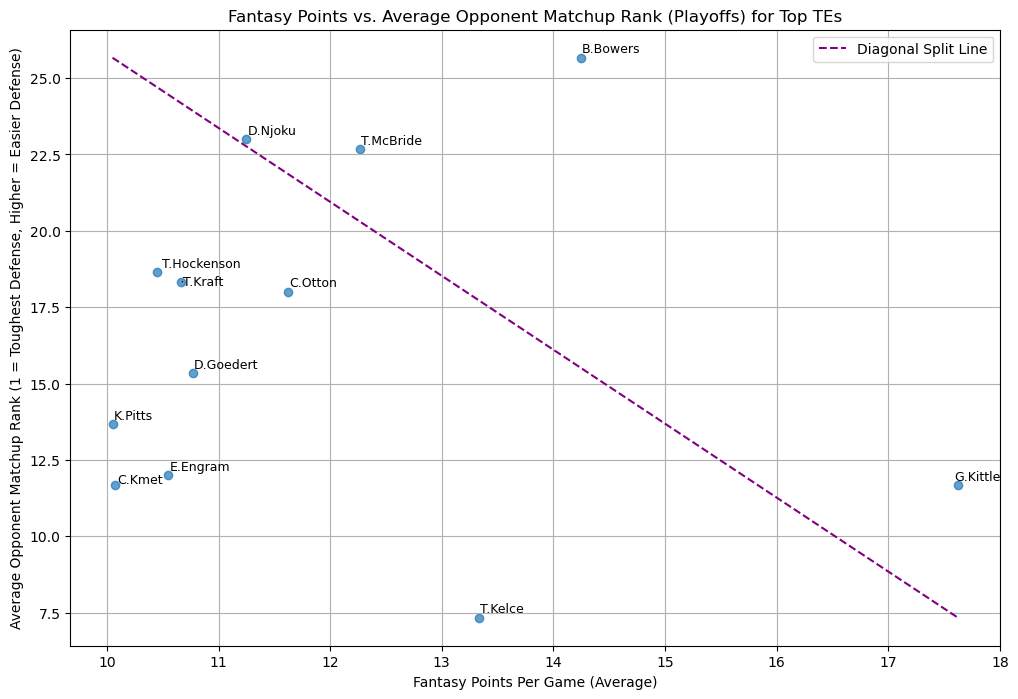

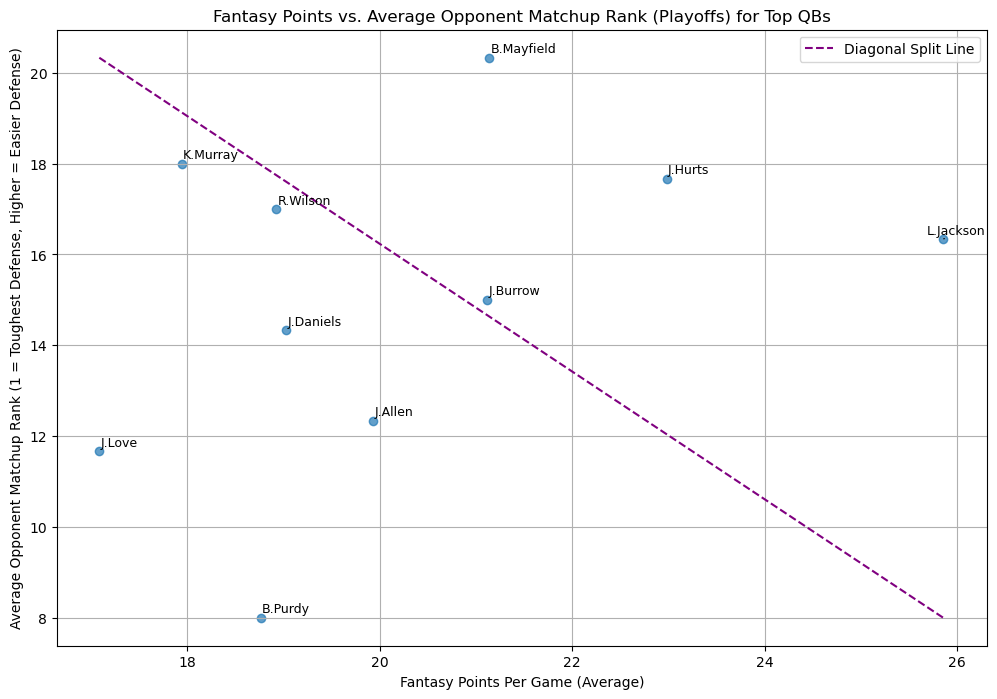

In [ ]:
def calculate_top_player_matchup(schedule_df, week_by_week_df, start_week=1, end_week=18): 
    
    defenseRankings_df = fantasy_defense_rankings(week_by_week_df).set_index("opponent_team")
    
    # creating a dataframe with the team and their matchups for the rest of the season
    matchups_data = []
    listOfTeams = week_by_week_df["recent_team"].unique()
    
    for team in listOfTeams:
        team_matchups = get_team_schedule(schedule_df, team, start_week, end_week)
        
        # precompute opponent ranks for each position using dictionary lookups
        qb_opponent_ranks = [defenseRankings_df.at[opponent, "QB_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        rb_opponent_ranks = [defenseRankings_df.at[opponent, "RB_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        wr_opponent_ranks = [defenseRankings_df.at[opponent, "WR_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        te_opponent_ranks = [defenseRankings_df.at[opponent, "TE_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]

        # calculate the average ranks
        qb_opponent_average = np.nanmean(qb_opponent_ranks)
        rb_opponent_average = np.nanmean(rb_opponent_ranks)
        wr_opponent_average = np.nanmean(wr_opponent_ranks)
        te_opponent_average = np.nanmean(te_opponent_ranks)
        
        # append to the matchups list
        matchups_data.append({
            "team": team,
            "matchups": team_matchups,
            "qb_opponent_average": qb_opponent_average,
            "rb_opponent_average": rb_opponent_average,
            "wr_opponent_average": wr_opponent_average,
            "te_opponent_average": te_opponent_average
        })

    matchups_df = pd.DataFrame(matchups_data)
         
    #trying to filter out the injured players
    latest_week = week_by_week_df["week"].max()
    recent_games_df = week_by_week_df[
    week_by_week_df["week"].isin([latest_week - 2, latest_week - 1, latest_week])
]
    active_players = recent_games_df["player_name"].unique().tolist()
    active_players.append("N.Collins")

    fantasyAverage_df = (
    week_by_week_df.groupby(["player_name", "position", "recent_team"])
    .agg({"fantasy_points_ppr": "mean"})
    .reset_index()
    .sort_values("fantasy_points_ppr", ascending=False)
)
    fantasyAverage_df = fantasyAverage_df[fantasyAverage_df["player_name"].isin(active_players)]
    # getting the top 30 fantasy performers of each of three positions 
    top10_qb = fantasyAverage_df[fantasyAverage_df["position"] == "QB"].head(10)
    top30_rb = fantasyAverage_df[fantasyAverage_df["position"] == "RB"].head(30)
    top30_wr = fantasyAverage_df[fantasyAverage_df["position"] == "WR"].head(30)
    top12_te = fantasyAverage_df[fantasyAverage_df["position"] == "TE"].head(12)
    
    # if necessary i can get full weekbyweek data (this would be better for calculating a composite score and factor in other factors)
    # top_rb_weekly = week_by_week_df[week_by_week_df['player_name'].isin(top_rb["player_name"])]
    # top_wr_weekly = week_by_week_df[week_by_week_df['player_name'].isin(top_wr["player_name"])]
    # top_te_weekly = week_by_week_df[week_by_week_df['player_name'].isin(top_te["player_name"])]
    
    # merge the top30 rb with the matchups_df
    top30_rb_matchups = top30_rb.merge(matchups_df, left_on="recent_team", right_on="team", how="left")
    top30_wr_matchups = top30_wr.merge(matchups_df, left_on="recent_team", right_on="team", how="left")
    top12_te_matchups = top12_te.merge(matchups_df, left_on="recent_team", right_on="team", how="left")
    top10_qb_matchups = top10_qb.merge(matchups_df, left_on="recent_team", right_on="team", how="left")
    
    return top10_qb_matchups, top30_rb_matchups, top30_wr_matchups, top12_te_matchups

def plot_fantasy_vs_matchup(data_df, position, playoffs= True, file_path = "visuals/fantasy_vs_matchup.png"):
    plt.figure(figsize=(12, 8))

    # create the scatter plot
    scatter = plt.scatter(
        data_df["fantasy_points_ppr"],
        data_df[f"{position.lower()}_opponent_average"],
        alpha=0.7
    )

    # add text annotations for each player
    texts = [
        plt.text(
            row["fantasy_points_ppr"],
            row[f"{position.lower()}_opponent_average"],
            row["player_name"],
            fontsize=9
        )
        for index, row in data_df.iterrows()
    ]

    # adjust the text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

     # calculate the plot limits
    min_fantasy_points = data_df["fantasy_points_ppr"].min()
    max_fantasy_points = data_df["fantasy_points_ppr"].max()
    min_opponent_rank = data_df[f"{position.lower()}_opponent_average"].min()
    max_opponent_rank = data_df[f"{position.lower()}_opponent_average"].max()

    # draw a diagonal line from top left (easiest matchups, low PPG) to bottom right (hardest matchups, high PPG)
    plt.plot(
        [min_fantasy_points, max_fantasy_points],  # x-axis (fantasy points)
        [max_opponent_rank, min_opponent_rank],    # y-axis (opponent rank)
        color='purple',
        linestyle='--',
        label='Diagonal Split Line'
    )

    plt.legend()
    
    # labels and title
    plt.xlabel("Fantasy Points Per Game (Average)")
    plt.ylabel("Average Opponent Matchup Rank (1 = Toughest Defense, Higher = Easier Defense)")
    if playoffs:
        plt.title(f"Fantasy Points vs. Average Opponent Matchup Rank (Playoffs) for Top {position}s")
    else:
        plt.title(f"Fantasy Points vs. Average Opponent Matchup Rank (Rest of Season) for Top {position}s")
    plt.grid()
    plt.show()
    plt.savefig(file_path)
    
top10_qb, top30_rb, top30_wr, top12_te = calculate_top_player_matchup(schedule2024, week_by_week2024, 15, 17)

plot_fantasy_vs_matchup(top30_rb, "RB")
plot_fantasy_vs_matchup(top30_wr, "WR")
plot_fantasy_vs_matchup(top12_te, "TE")
plot_fantasy_vs_matchup(top10_qb, "QB")


In [26]:
def get_defense_matchups (schedule_df, week_by_week_df, start_week = 1, end_week = 18): 
    defenseRankings_df = fantasy_defense_rankings(week_by_week_df).set_index("opponent_team")
    
    # creating a dataframe with the team and their matchups for the rest of the season
    matchups_data = []
    listOfTeams = week_by_week_df["recent_team"].unique()
    
    for team in listOfTeams:
        team_matchups = get_team_schedule(schedule_df, team, start_week=start_week, end_week=end_week)

        # precompute opponent ranks for each position using dictionary lookups
        qb_opponent_ranks = [defenseRankings_df.at[opponent, "QB_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        rb_opponent_ranks = [defenseRankings_df.at[opponent, "RB_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        wr_opponent_ranks = [defenseRankings_df.at[opponent, "WR_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]
        te_opponent_ranks = [defenseRankings_df.at[opponent, "TE_rank"] if opponent in defenseRankings_df.index else np.nan for opponent in team_matchups]

        # calculate the average ranks
        qb_opponent_average = np.nanmean(qb_opponent_ranks)
        rb_opponent_average = np.nanmean(rb_opponent_ranks)
        wr_opponent_average = np.nanmean(wr_opponent_ranks)
        te_opponent_average = np.nanmean(te_opponent_ranks)
        
        # append to the matchups list
        matchups_data.append({
            "team": team,
            "matchups": team_matchups,
            "qb_opponent_average": qb_opponent_average,
            "rb_opponent_average": rb_opponent_average,
            "wr_opponent_average": wr_opponent_average,
            "te_opponent_average": te_opponent_average
        })

    matchups_df = pd.DataFrame(matchups_data)
    
    return matchups_df

get_defense_matchups(schedule_df=schedule2024, week_by_week_df=week_by_week2024, start_week=11,end_week=17)

,team,matchups,qb_opponent_average,rb_opponent_average,wr_opponent_average,te_opponent_average
0,NYJ,"[IND, BYE, SEA, MIA, JAX, LA, BUF]",16.333333,21.166667,18.833333,19.833333
1,CHI,"[GB, MIN, DET, SF, MIN, DET, SEA]",8.714286,11.428571,22.714286,11.285714
2,IND,"[NYJ, DET, NE, BYE, DEN, TEN, NYG]",14.666667,15.666667,11.666667,9.000000
3,BAL,"[PIT, LAC, PHI, BYE, NYG, PIT, HOU]",10.333333,11.500000,12.666667,8.500000
4,LA,"[NE, PHI, NO, BUF, SF, NYJ, ARI]",11.571429,21.714286,14.142857,11.428571
5,CAR,"[BYE, KC, TB, PHI, DAL, ARI, TB]",22.000000,17.500000,17.666667,20.333333
6,CLE,"[NO, PIT, DEN, PIT, KC, CIN, MIA]",10.428571,16.000000,10.000000,19.857143
7,PIT,"[BAL, CLE, CIN, CLE, PHI, BAL, KC]",21.285714,5.571429,20.714286,18.000000
8,ATL,"[DEN, BYE, LAC, MIN, LV, NYG, WAS]",15.000000,13.000000,13.500000,14.333333
9,DAL,"[HOU, WAS, NYG, CIN, CAR, TB, PHI]",23.000000,16.142857,22.142857,16.571429


In [27]:
def get_team_schedule (schedule_df,team_name, start_week = 1 , end_week = 18): 
    # filter rows where the team is either the home or away team
    team_home_games = schedule_df[schedule_df['home_team'] == team_name]
    team_away_games = schedule_df[schedule_df['away_team'] == team_name]

    # create lists of matchups
    home_games = [row['away_team'] for _, row in team_home_games.iterrows()]
    away_games = [row['home_team'] for _, row in team_away_games.iterrows()]

   # create a full schedule for the team
    home_schedule = team_home_games[['week']].assign(matchup=home_games)
    away_schedule = team_away_games[['week']].assign(matchup=away_games)
    full_schedule = pd.concat([home_schedule, away_schedule], ignore_index=True).sort_values(by='week').reset_index(drop=True)
   
    # identify bye weeks (weeks where the team is not playing)
    all_weeks = set(range(1, 18))
    played_weeks = set(full_schedule['week'])
    bye_weeks = list(all_weeks - played_weeks)

    # add bye weeks to the schedule
    bye_schedule = pd.DataFrame({"week": bye_weeks, "matchup": ["BYE"] * len(bye_weeks)})
    full_schedule = pd.concat([full_schedule, bye_schedule], ignore_index=True).sort_values(by='week').reset_index(drop=True)
    
    schedule_list = full_schedule['matchup'].tolist()

    # account for a specific range of weeks
    sorted_schedule_list = schedule_list[(start_week - 1):(end_week)]

    return sorted_schedule_list
    
    
    
    

team_name = "NYJ" 
nyj_schedule = get_team_schedule(schedule2024, team_name, 12, 18)
print(nyj_schedule)

['BYE', 'SEA', 'MIA', 'JAX', 'LA', 'BUF', 'MIA']


In [13]:
smallWeekByWeek_df = week_by_week2024[['position', 'position_group']]

# getting fantasy defense ranking through week by week data
def fantasy_defense_rankings(week_by_week_df): 
    smallFantasy_df = week_by_week_df[['fantasy_points_ppr', 'position', 'opponent_team', 'player_name', 'week']]
    releventPositions_df = smallFantasy_df[smallFantasy_df['position'].isin(['QB', 'RB', 'WR', 'TE'])]
    
    # using top performers b/c thats usually more indicative of sos in fantasy football 
    topPerformers_df = releventPositions_df.sort_values(by='fantasy_points_ppr', ascending=False).groupby(['opponent_team', 'position']).head(10) # can use .head() if i want to see top performer averages
    
    
    # groupy by opponent team and position in order to find out how many total fantasy points each position has scored against them 
    defensePointsAgainst = topPerformers_df.groupby(['opponent_team', 'position'])['fantasy_points_ppr'].mean().reset_index()
    
    # assign a rank to each team based on the total fantasy points scored against them
    defensePointsAgainst['rank'] = defensePointsAgainst.groupby('position')['fantasy_points_ppr'].rank(ascending=True)
    
    defensePointsAgainst = defensePointsAgainst.sort_values(by=['position', 'rank'])
    
    # pivot the table so that the rankings are in the same row as the team name
    defenseRankings = defensePointsAgainst.pivot(index = "opponent_team", columns = "position", values = "rank")
    defensePPRPoints = defensePointsAgainst.pivot(index = "opponent_team", columns = "position", values = "fantasy_points_ppr")
    
    defenseRankings = defenseRankings.reset_index()
    defensePPRPoints = defensePPRPoints.reset_index()
    
    # merge the rankings and the average ppr points scored against each team
    defenseRankings = defenseRankings.merge(defensePPRPoints, on = "opponent_team", suffixes = ("_rank", "_ppr_avg"))

    return defenseRankings


def merge_defense_schedule (schedule_df, defense_df): 
    home_df = defense_df.add_suffix("_home")
    scheduleWithDefense = schedule_df.merge(home_df, left_on="home_team", right_on="opponent_team_home", how="left", suffixes=("", "_home"))
    scheduleWithDefense = scheduleWithDefense.merge(defense_df, left_on="away_team", right_on="opponent_team", how="left", suffixes=("", "_away"))
    scheduleWithDefense = scheduleWithDefense.drop(columns=["opponent_team_home", "opponent_team_away"], errors="ignore")
    return scheduleWithDefense

test = fantasy_defense_rankings(week_by_week2024)


test

position,opponent_team,QB_rank,RB_rank,TE_rank,WR_rank,QB_ppr_avg,RB_ppr_avg,TE_ppr_avg,WR_ppr_avg
0,ARI,20.0,22.0,10.0,12.0,15.772000,17.160000,8.040000,16.820000
1,ATL,27.0,20.0,25.0,24.0,17.434000,16.830000,11.290000,20.260000
2,BAL,31.0,6.0,28.0,32.0,22.198000,14.520000,12.629999,28.207998
3,BUF,11.0,31.0,9.0,9.0,13.283999,21.439999,7.800000,16.430000
4,CAR,26.0,30.0,26.0,21.0,17.360001,20.580000,11.710000,19.152000
5,CHI,1.0,9.0,16.0,4.0,9.360000,15.150000,9.059999,14.370000
6,CIN,29.0,15.0,31.0,22.0,19.184000,15.990001,13.110001,19.340000
7,CLE,19.0,5.0,3.0,19.0,14.948000,13.630000,6.640000,18.770000
8,DAL,28.0,28.0,15.0,11.0,18.326000,19.340000,9.010000,16.710001
9,DEN,9.0,10.0,20.0,5.0,13.068001,15.270000,9.670000,15.480000


In [ ]:
scheduleWithDefense[['away_team','home_team','QB_rank_home', 'RB_rank_home', 'TE_rank_home',
       'WR_rank_home', 'QB_ppr_avg_home', 'RB_ppr_avg_home', 'TE_ppr_avg_home',
       'WR_ppr_avg_home', 'opponent_team', 'QB_rank', 'RB_rank', 'TE_rank',
       'WR_rank', 'QB_ppr_avg', 'RB_ppr_avg', 'TE_ppr_avg', 'WR_ppr_avg']]

NameError: name 'scheduleWithDefense' is not defined

In [ ]:
# creating a function to calculate the win/loss ratio for each team given the seasonal data
def win_loss (schedule_df): 
    # making the dataframe smaller so its easier to handle the data
    smallSchedule2024 = schedule_df[['result', 'away_team', 'away_score', 'home_team', 'home_score', 'week']]   
    previousGames = smallSchedule2024[schedule_df['result'].notnull()]
    
    
    previousGames['home_win'] = np.where(previousGames['result'] > 0, 1, 0)
    previousGames['away_win'] = np.where(previousGames['result'] < 0, 1, 0)
    
    ## not sure if all this is necessary. I think the best way to do it would be to just count the 1s and 0s to figure out the record
    # obtaining the week list
    weekList = previousGames['week'].unique()
    
    #going week by week to calculate the records
    for week in weekList: 
        # getting the data for each week at a time (to tally up the win/loss at the specific time of playing)
        previousWeekData = previousGames[previousGames['week'] <= week]
        
        # calculating the wins and losses for each team
        homeWins = previousWeekData.groupby('home_team')['home_win'].sum()
        awayWins = previousWeekData.groupby('away_team')['away_win'].sum()
        homeLosses = previousWeekData.groupby('home_team')['home_win'].count() - previousWeekData.groupby('home_team')['home_win'].sum()
        awayLosses = previousWeekData.groupby('away_team')['away_win'].count() - previousWeekData.groupby('away_team')['away_win'].sum()
        
        teamWins = homeWins.add(awayWins, fill_value=0)
        teamLosses = homeLosses.add(awayLosses, fill_value=0)
        
        # creates a mask so we get the right week in the origianl df
        mask = schedule_df['week'] == week

        # adding the win/loss record to the schedule_df
        schedule_df.loc[mask, 'home_team_win_record'] = schedule_df['home_team'].map(teamWins)
        schedule_df.loc[mask, 'home_team_loss_record'] = schedule_df['home_team'].map(teamLosses)
        schedule_df.loc[mask, 'away_team_win_record'] = schedule_df['away_team'].map(teamWins)
        schedule_df.loc[mask, 'away_team_loss_record'] = schedule_df['away_team'].map(teamLosses)

    return schedule_df


scheduleWithRecords = win_loss(schedule2024) 
previousGames = scheduleWithRecords[scheduleWithRecords['result'].notnull()]
previousGames
